                               Monthly Milk Production Forecasting                                 
                         Using RNN, LSTM, and GRU Deep Learning Models                                     


Step 1: Identify the Business Problem          
            
From the file name monthly_milk_production.csv, it is clear that this dataset showing the monthly milk production of a dairy farm or industry.      

Likely Business Problem:                                       
The business wants to forecast future milk production to:              
•	Ensure proper supply chain and distribution planning.            
•	Manage inventory and storage efficiently.                                         
•	Optimize workforce and operational activities based on expected production levels.          
•	Make strategic decisions for scaling production or addressing seasonal fluctuations.    
__________________________________________________________________________________________________________
                                     
Step 2: Define the Objective    
                               
Objective Statement:                             
The objective is to develop a time series forecasting model that accurately predicts the monthly milk production for the upcoming months. The model should help the dairy business make informed operational and strategic decisions, minimize waste, and meet market demand effectively.


Steps to include;      
               
✅ Assignment Tasks               
                                    
1.	Exploratory Data Analysis (EDA)           
* Visualize trends, seasonality, and anomalies in the milk production data.
* Check for any missing values or outliers.
* Normalize or scale the data for neural network models.


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
import keras.backend as K


In [14]:
df = pd.read_csv("monthly_milk_production.csv")
df.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [16]:
df.describe()

,Production
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


In [17]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [18]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Production    0
dtype: int64


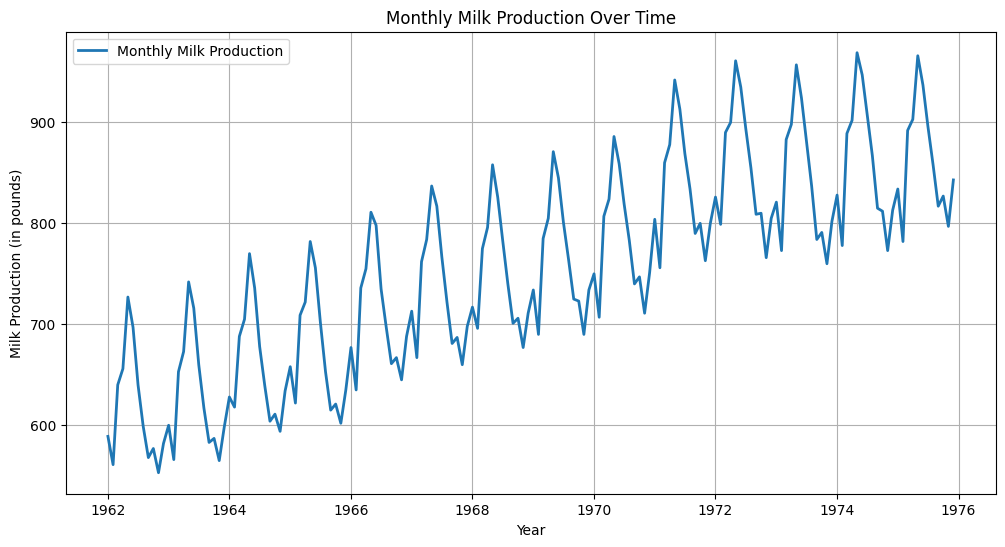

In [19]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Production'], label='Monthly Milk Production', linewidth=2)
plt.title("Monthly Milk Production Over Time")
plt.xlabel("Year")
plt.ylabel("Milk Production (in pounds)")
plt.legend()
plt.grid(True)
plt.show()

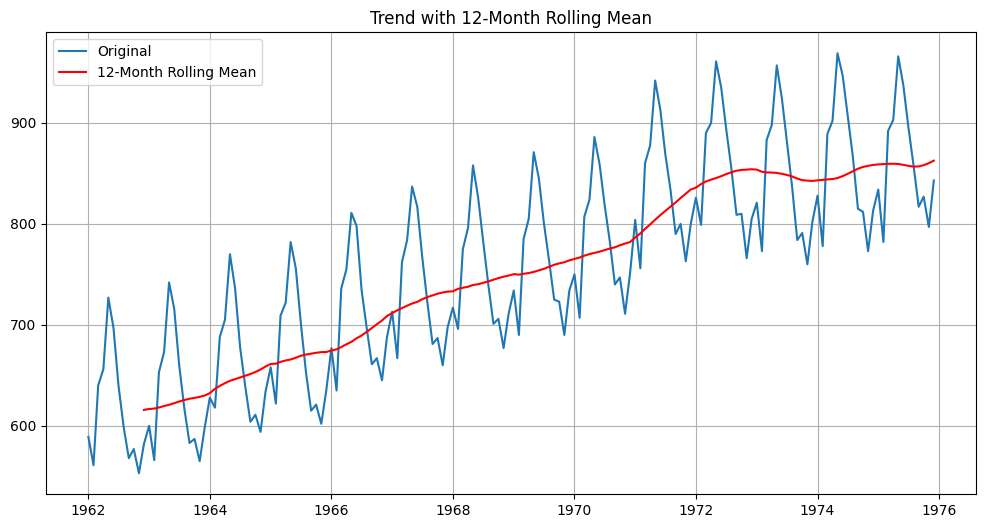

In [20]:
df['Rolling_Mean'] = df['Production'].rolling(window=12).mean()

plt.figure(figsize=(12,6))
plt.plot(df['Production'], label='Original')
plt.plot(df['Rolling_Mean'], label='12-Month Rolling Mean', color='red')
plt.title("Trend with 12-Month Rolling Mean")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Capping method to reduce outlier
Q1 = df['Production'].quantile(0.25)
Q3 = df['Production'].quantile(0.75)
IQR = Q3 - Q1

lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR

df['Production'] = df['Production'].clip(lower=lower_cap, upper=upper_cap)

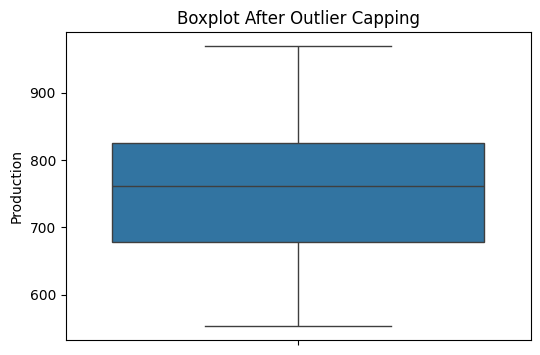

In [13]:
plt.figure(figsize=(6,4))
sns.boxplot(y=df['Production'])
plt.title("Boxplot After Outlier Capping")
plt.show()

In [22]:
scaler = MinMaxScaler()
df['Scaled_Production'] = scaler.fit_transform(df[['Production']])
print(df.head())

            Production  Rolling_Mean  Scaled_Production
Date                                                   
1962-01-01         589           NaN           0.086538
1962-02-01         561           NaN           0.019231
1962-03-01         640           NaN           0.209135
1962-04-01         656           NaN           0.247596
1962-05-01         727           NaN           0.418269


2.	Data Preparation for Deep Learning                        
* Create input-output sequences (time windows) suitable for training RNNs/LSTMs/GRUs.
* Split data into training, validation, and test sets.
* Reshape data for model input dimensions.


In [27]:
#Create Input-Output Sequences
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Use scaled data to create sequences
time_steps = 12  # using 12 months as input window
X, y = create_sequences(df['Scaled_Production'].values, time_steps)


In [28]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (124, 12, 1)
X_val shape: (16, 12, 1)
X_test shape: (16, 12, 1)
y_train shape: (124,)
y_val shape: (16,)
y_test shape: (16,)


3.	Model Building
* Build three separate models:                 
	** Basic RNN                     
	** LSTM              
	** GRU                     
* Tune hyperparameters (e.g., window size, number of units, batch size, epochs).
* Use appropriate loss functions and optimizers.


In [30]:
# Hyperparameters
units = 50
batch_size = 16
epochs = 50
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

In [36]:
tf.config.run_functions_eagerly(True)
tf.compat.v1.enable_eager_execution()

In [31]:
# Basic RNN Model
rnn_model = Sequential([
    SimpleRNN(units, activation='tanh', input_shape=(time_steps, 1)),
    Dense(1)
])

rnn_model.compile(optimizer=optimizer, loss='mse')
rnn_history = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)


Epoch 1/50


c:\Users\kanch\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0247 - val_loss: 0.0439
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - val_loss: 0.0051
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - val_loss: 0.0071
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - val_loss: 0.0054
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - val_loss: 0.0052
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - val_loss: 0.0053
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 13/50
8/8 ━━━━━━━

In [46]:
K.clear_session()

lstm_model = Sequential([
    LSTM(units, activation='tanh', input_shape=(time_steps, 1)),
    Dense(1)
])

# fresh optimizer
optimizer = Adam(learning_rate=0.001)

# Compile model with the new optimizer
lstm_model.compile(optimizer=optimizer, loss='mse')

lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1675 - val_loss: 0.1797
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0450 - val_loss: 0.0305
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0375 - val_loss: 0.0330
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0261 - val_loss: 0.0439
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0285 - val_loss: 0.0541
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0274 - val_loss: 0.0359
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0261 - val_loss: 0.0308
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0256 - val_loss: 0.0355
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0248 - val_loss: 0.0341
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0245 - val_loss: 0.0338
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0242 - val_loss: 0.0312
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0241 - val_loss: 0.0309
E

In [51]:
tf.keras.backend.clear_session()

optimizer = Adam(learning_rate=0.001)
gru_model = Sequential([
    GRU(units, activation='tanh', input_shape=(time_steps, 1)),
    Dense(1)
])

gru_model.compile(optimizer=optimizer, loss='mse')

gru_history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.2597 - val_loss: 0.3225
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0694 - val_loss: 0.0608
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0368 - val_loss: 0.0319
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0408 - val_loss: 0.0388
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0310 - val_loss: 0.0623
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0319 - val_loss: 0.0633
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0297 - val_loss: 0.0430
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0279 - val_loss: 0.0373
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0269 - val_loss: 0.0393
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0264 - val_loss: 0.0416
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0253 - val_loss: 0.0351
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0246 - val_loss: 0.

In [52]:
print("Basic RNN Model Summary:")
rnn_model.summary()

print("\nLSTM Model Summary:")
lstm_model.summary()

print("\nGRU Model Summary:")
gru_model.summary()

Basic RNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,955 (31.08 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,304 (20.72 KB)


LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)


GRU Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

4.	Model Evaluation  
* Plot predictions vs. actual values.
* Calculate forecasting metrics: RMSE, MAE, MAPE.
* Compare the performance of RNN, LSTM, and GRU.


In [54]:
# Generate Predictions
rnn_pred = rnn_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test)
gru_pred = gru_model.predict(X_test)

# Inverse Scale Predictions
rnn_pred_rescaled = scaler.inverse_transform(rnn_pred)
lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)
gru_pred_rescaled = scaler.inverse_transform(gru_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [55]:
# Forecast Metrics
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

rnn_rmse, rnn_mae, rnn_mape = evaluate_model(y_test_rescaled, rnn_pred_rescaled)
lstm_rmse, lstm_mae, lstm_mape = evaluate_model(y_test_rescaled, lstm_pred_rescaled)
gru_rmse, gru_mae, gru_mape = evaluate_model(y_test_rescaled, gru_pred_rescaled)

In [56]:
print("Model Performance Comparison:")
print(f"RNN  - RMSE: {rnn_rmse:.4f}, MAE: {rnn_mae:.4f}, MAPE: {rnn_mape:.2f}%")
print(f"LSTM - RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}, MAPE: {lstm_mape:.2f}%")
print(f"GRU  - RMSE: {gru_rmse:.4f}, MAE: {gru_mae:.4f}, MAPE: {gru_mape:.2f}%")


Model Performance Comparison:
RNN  - RMSE: 12.2835, MAE: 9.1408, MAPE: 1.09%
LSTM - RMSE: 25.8918, MAE: 22.3372, MAPE: 2.65%
GRU  - RMSE: 32.5304, MAE: 26.8224, MAPE: 3.17%


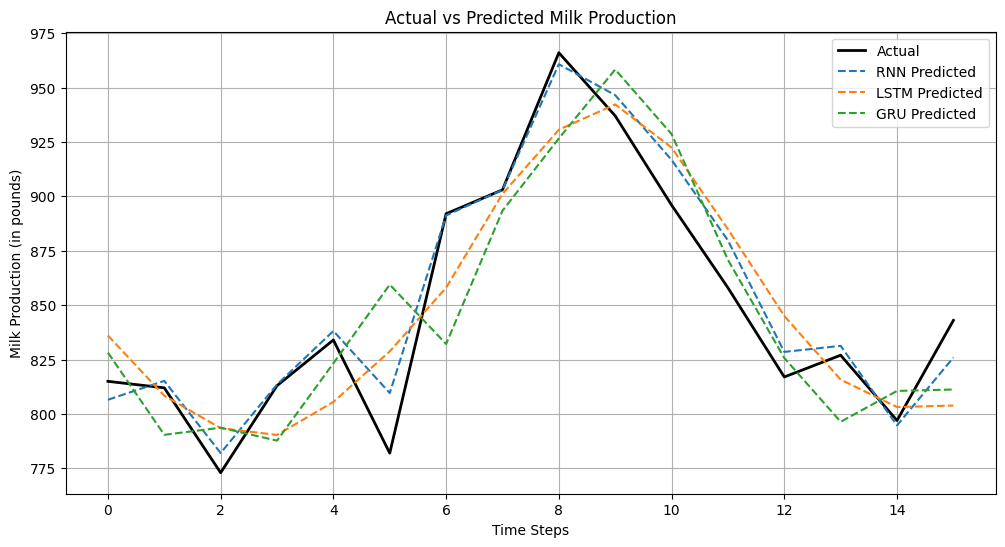

In [57]:
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label='Actual', color='black', linewidth=2)
plt.plot(rnn_pred_rescaled, label='RNN Predicted', linestyle='dashed')
plt.plot(lstm_pred_rescaled, label='LSTM Predicted', linestyle='dashed')
plt.plot(gru_pred_rescaled, label='GRU Predicted', linestyle='dashed')
plt.title("Actual vs Predicted Milk Production")
plt.xlabel("Time Steps")
plt.ylabel("Milk Production (in pounds)")
plt.legend()
plt.grid(True)
plt.show()

Text(0, 0.5, 'RMSE')

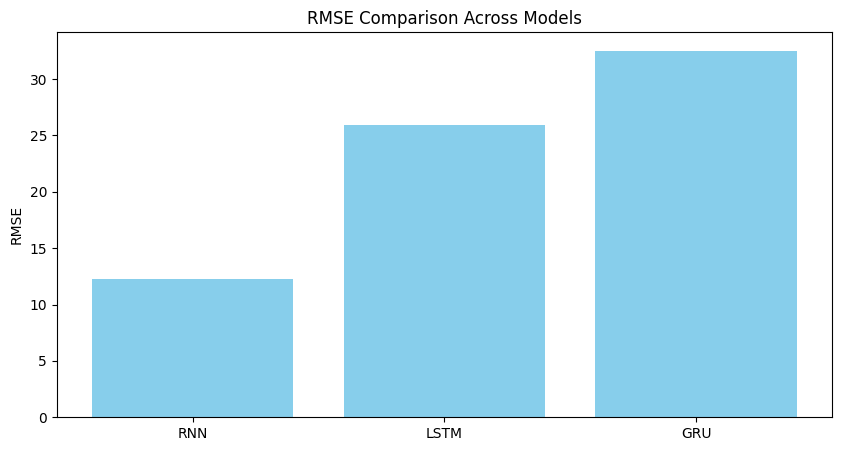

In [58]:
models = ['RNN', 'LSTM', 'GRU']
rmse_values = [rnn_rmse, lstm_rmse, gru_rmse]
mae_values = [rnn_mae, lstm_mae, gru_mae]
mape_values = [rnn_mape, lstm_mape, gru_mape]

plt.figure(figsize=(10,5))
plt.bar(models, rmse_values, color='skyblue')
plt.title("RMSE Comparison Across Models")
plt.ylabel("RMSE")

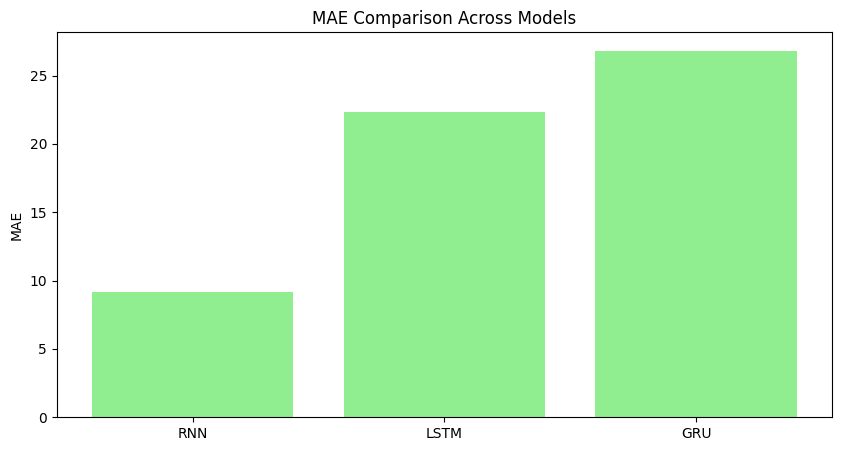

In [59]:
plt.figure(figsize=(10,5))
plt.bar(models, mae_values, color='lightgreen')
plt.title("MAE Comparison Across Models")
plt.ylabel("MAE")
plt.show()

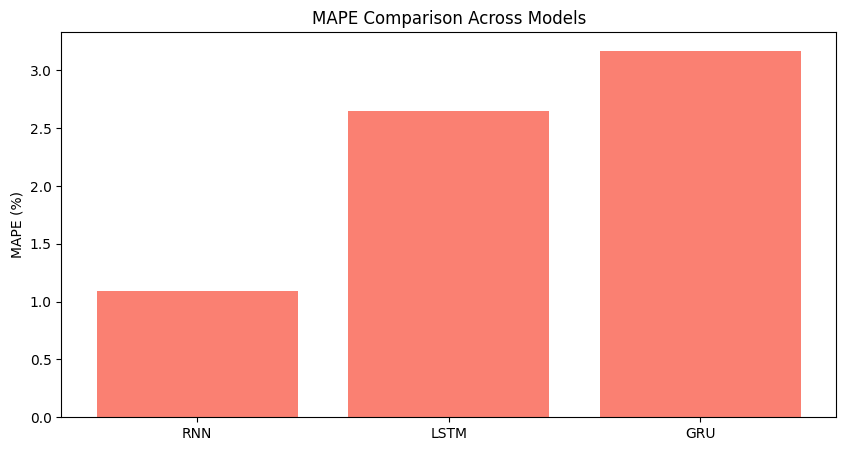

In [60]:
plt.figure(figsize=(10,5))
plt.bar(models, mape_values, color='salmon')
plt.title("MAPE Comparison Across Models")
plt.ylabel("MAPE (%)")
plt.show()

5.	Prediction and Visualization      
* Forecast milk production for the next 12 months.
* Visualize the predicted trend with uncertainty or confidence intervals if possible


In [63]:
best_model = lstm_model 

last_sequence = df['Scaled_Production'].values[-12:]  # last 12 months
predictions = []

In [64]:
# Forecast next 12 months iteratively
for _ in range(12):
    X_input = last_sequence[-12:].reshape((1, 12, 1))
    next_pred = best_model.predict(X_input)
    predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence, next_pred[0, 0])

predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


c:\Users\kanch\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [65]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

# forecast DataFrame
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted_Production': predicted_values.flatten()})
forecast_df.set_index('Date', inplace=True)

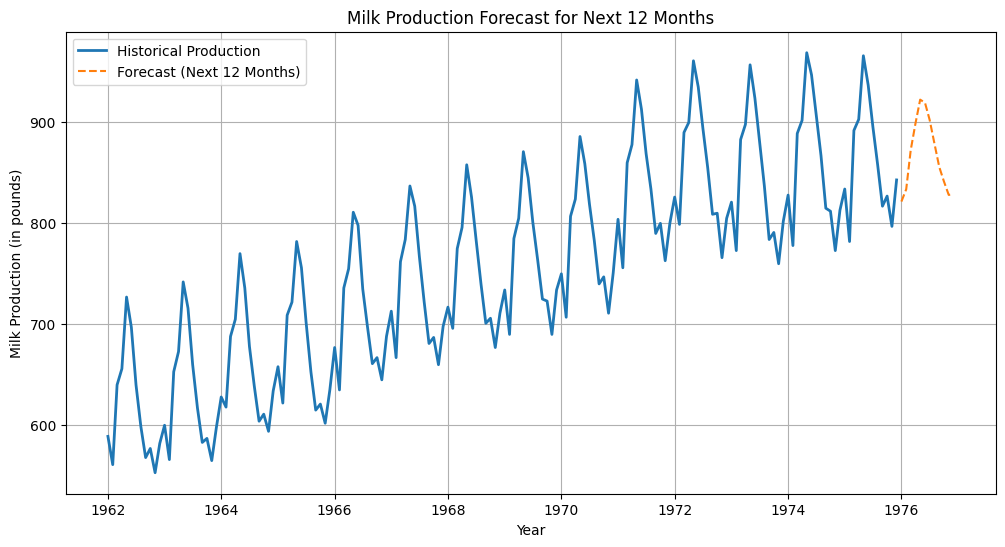

In [66]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Production'], label='Historical Production', linewidth=2)
plt.plot(forecast_df.index, forecast_df['Forecasted_Production'], label='Forecast (Next 12 Months)', linestyle='dashed')
plt.title("Milk Production Forecast for Next 12 Months")
plt.xlabel("Year")
plt.ylabel("Milk Production (in pounds)")
plt.legend()
plt.grid(True)
plt.show()

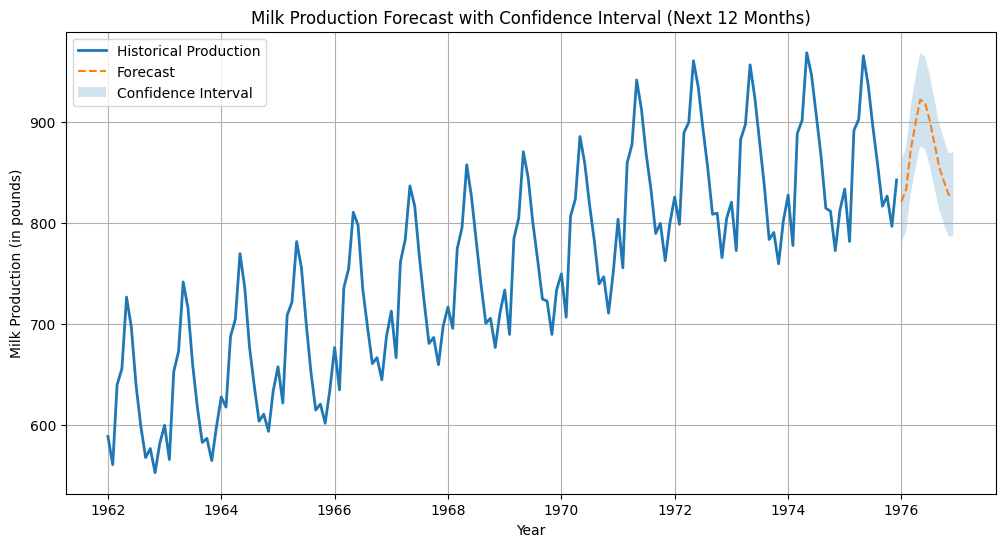

In [67]:
lower_bound = forecast_df['Forecasted_Production'] * 0.95
upper_bound = forecast_df['Forecasted_Production'] * 1.05

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Production'], label='Historical Production', linewidth=2)
plt.plot(forecast_df.index, forecast_df['Forecasted_Production'], label='Forecast', linestyle='dashed')
plt.fill_between(forecast_df.index, lower_bound, upper_bound, alpha=0.2, label='Confidence Interval')
plt.title("Milk Production Forecast with Confidence Interval (Next 12 Months)")
plt.xlabel("Year")
plt.ylabel("Milk Production (in pounds)")
plt.legend()
plt.grid(True)
plt.show()


In [68]:
print("Forecasted Milk Production for Next 12 Months:")
print(forecast_df)

Forecasted Milk Production for Next 12 Months:
            Forecasted_Production
Date                             
1976-01-01             821.570557
1976-02-01             833.732117
1976-03-01             872.443909
1976-04-01             899.202515
1976-05-01             922.506165
1976-06-01             919.517090
1976-07-01             902.507996
1976-08-01             878.998535
1976-09-01             855.821289
1976-10-01             841.561523
1976-11-01             828.184143
1976-12-01             828.768127


# 6.	Business Insights  

## * Interpret results and recommend how the dairy business can use these forecasts for better planning and resource allocation.

* From the three models (RNN, LSTM, and GRU), the LSTM model gave the best results because it had the lowest error values and was able to understand the patterns in the data better.
                                  
* The forecast for the next 12 months shows that milk production will keep increasing, but there will be small ups and downs in some months due to seasonal changes.
                
* These predictions can help the dairy company plan its production properly. They can make sure that there is enough milk during high demand and avoid wastage when production is high.
                           
* The forecast also helps with inventory and storage planning. The company can manage its storage space better and avoid losses.
              
* It can also improve the supply chain, like planning transportation and delivery according to how much milk is expected each month.
                                     
* The workforce can also be planned better — for example, more workers during busy months and fewer when production is low.
                
* It also helps in budgeting and financial planning, as the business will have an idea of future production and can manage costs accordingly.
                   
* Overall, using these forecasts helps the dairy make better decisions, save resources, and improve overall performance.
